In [1]:
!pip install opendatasets pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn tensorflow

In [1]:
import os
import json
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Manually set Kaggle credentials
KAGGLE_USERNAME = "tommciver"
KAGGLE_KEY = "44fd7907239dd2cbec103015c195106c"

# Ensure ~/.kaggle exists
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Create kaggle.json
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
kaggle_credentials = {"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}

with open(kaggle_json_path, "w") as f:
    json.dump(kaggle_credentials, f)

# Set correct permissions
os.chmod(kaggle_json_path, 0o600)

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Define dataset and target path
dataset = "mlg-ulb/creditcardfraud"
data_path = "./creditcardfraud"

if not os.path.exists(data_path):
    try:
        print(f"Downloading dataset: {dataset}...")
        api.dataset_download_files(dataset, path=data_path, unzip=True)
        print("Download complete!")
    except Exception as e:
        print(f"Error downloading dataset: {e}\nEnsure Kaggle credentials are correctly set up.")
        exit()
else:
    print("Dataset already downloaded.")


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
Download complete!


In [2]:
import pandas as pd

df = pd.read_csv(os.path.join(data_path, "creditcard.csv"))

print(df.info())
print("\nClass distribution:\n", df['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
# split
train_ratio = 0.6
val_ratio = 0.2

train_end = int(len(df) * train_ratio)
val_end = train_end + int(len(df) * val_ratio)


X = df.drop('Class', axis=1).values
y = df['Class'].values


X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (170884, 30)
Validation set shape: (56961, 30)
Test set shape: (56962, 30)


In [4]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_train[:, [0, -1]])  

def safe_scale(data, scaler, time_amount_indices):
    scaled = data.copy()
    scaled[:, time_amount_indices] = scaler.transform(scaled[:, time_amount_indices])
    return scaled

time_amount_idx = [0, -1]  
X_train = safe_scale(X_train, scaler, time_amount_idx)
X_val = safe_scale(X_val, scaler, time_amount_idx)
X_test = safe_scale(X_test, scaler, time_amount_idx)

print("Preprocessing complete!")

Preprocessing complete!


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))


scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("Class weights:", class_weights)
print("XGBoost scale_pos_weight:", scale_pos_weight)

Class weights: {0: 0.5010555698904553, 1: 237.3388888888889}
XGBoost scale_pos_weight: 473.6777777777778


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


lr = LogisticRegression(class_weight=class_weights, max_iter=1000)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(class_weight=class_weights, n_jobs=-1, oob_score=True, verbose=1)
rf.fit(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', early_stopping_rounds=50)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)


def create_nn():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn = create_nn()
history = nn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0
)

print("All models trained!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


All models trained!


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Evaluating Logistic Regression...


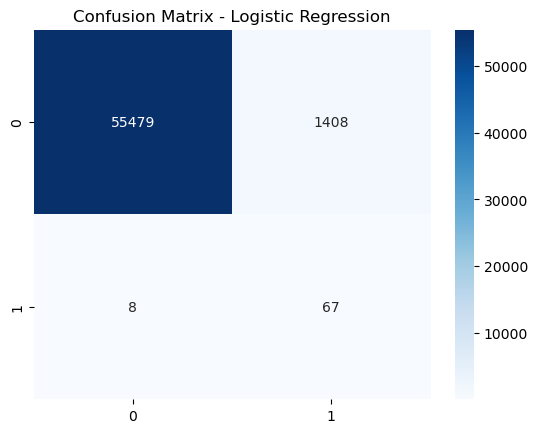

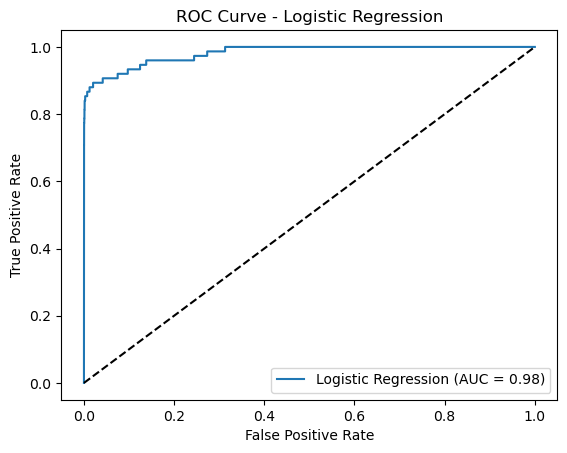

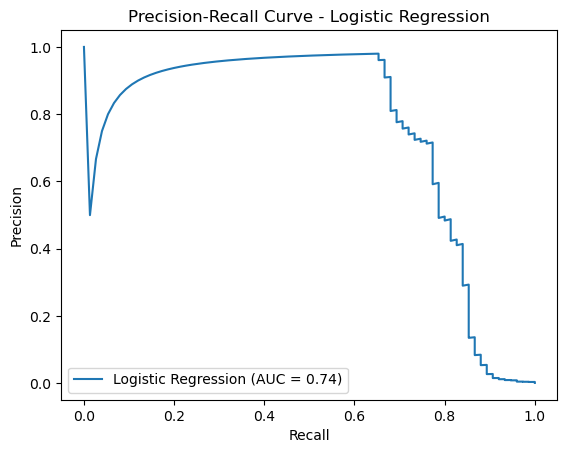


Evaluating Random Forest...


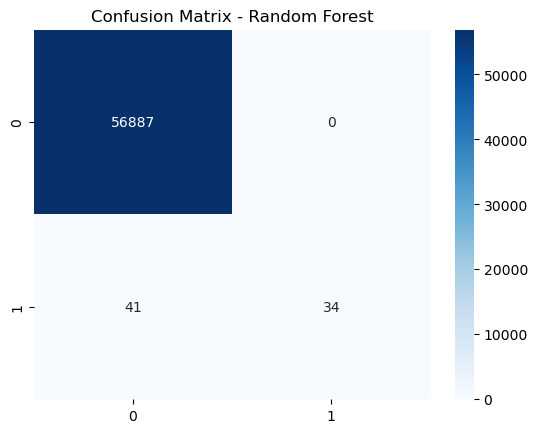

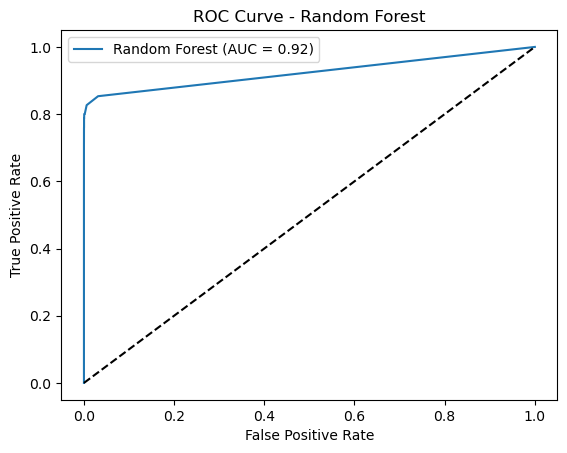

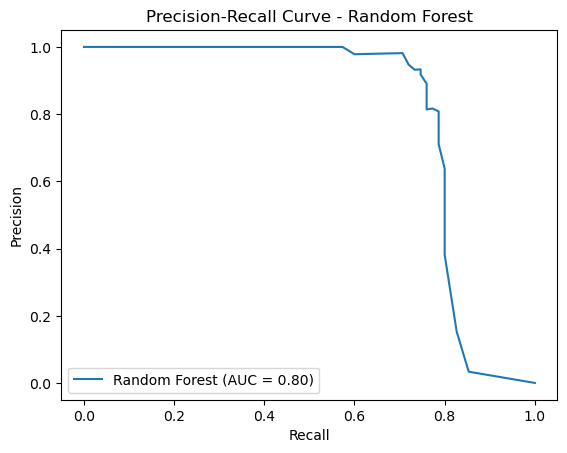


Evaluating XGBoost...


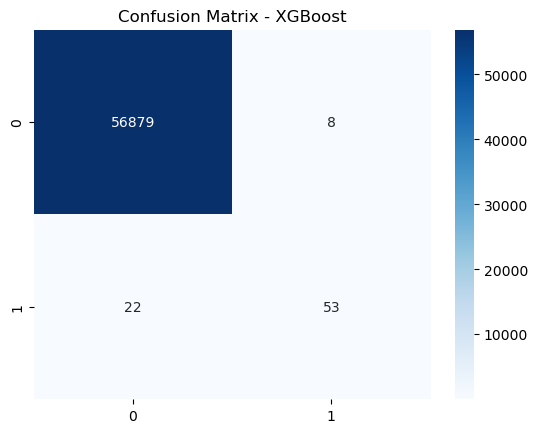

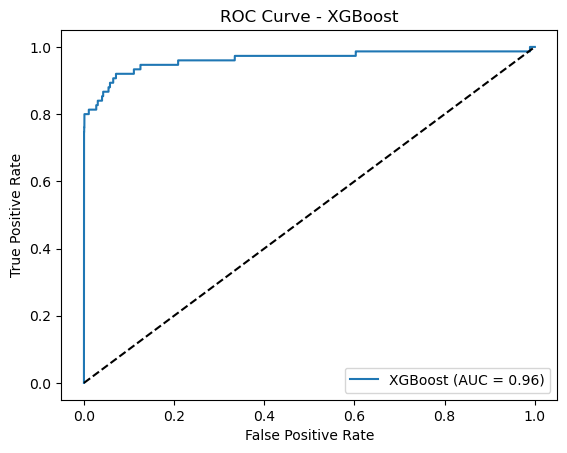

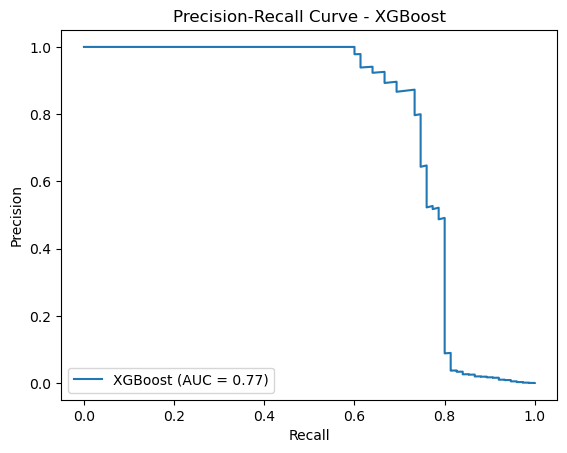


Evaluating Neural Network...


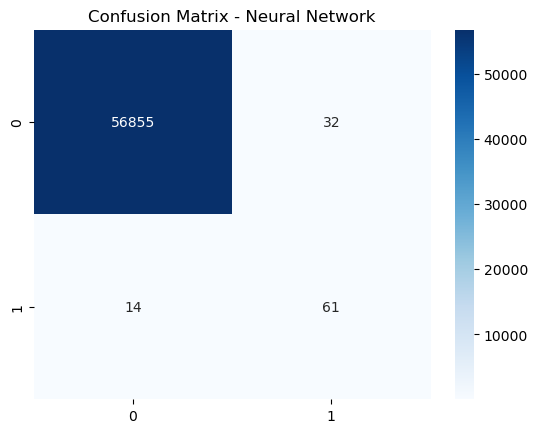

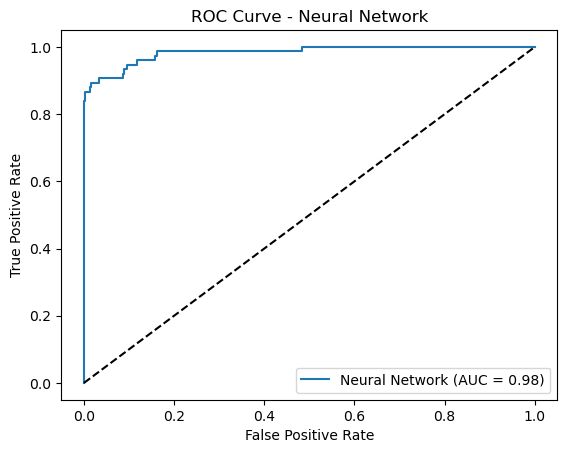

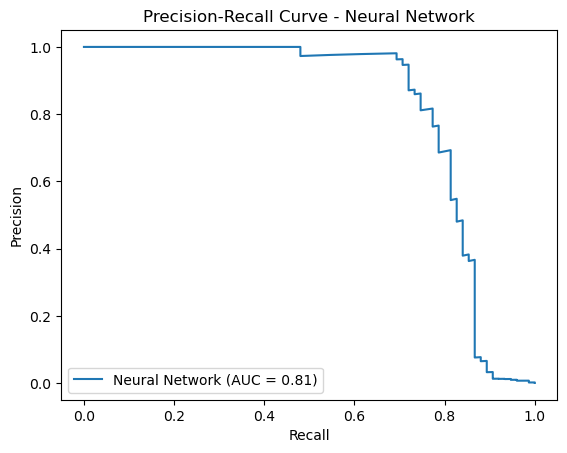


Model Performance Summary:
                 Model  Accuracy  Precision    Recall        F1   ROC AUC  \
0  Logistic Regression  0.975141   0.045424  0.893333  0.086452  0.981885   
1        Random Forest  0.999280   1.000000  0.453333  0.623853  0.923750   
2              XGBoost  0.999473   0.868852  0.706667  0.779412  0.962992   
3       Neural Network  0.999192   0.655914  0.813333  0.726190  0.983160   

     PR AUC  
0  0.742645  
1  0.797115  
2  0.765470  
3  0.814377  


In [7]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, y_true, y_pred, y_proba):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'PR AUC': auc(*precision_recall_curve(y_true, y_proba)[1::-1])
    }
    
    
    plt.figure()
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["ROC AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()
    

    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f'{name} (AUC = {metrics["PR AUC"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend()
    plt.show()
    
    return metrics


models = {
    'Logistic Regression': (lr.predict(X_test), lr.predict_proba(X_test)[:, 1]),
    'Random Forest': (rf.predict(X_test), rf.predict_proba(X_test)[:, 1]),
    'XGBoost': (xgb.predict(X_test), xgb.predict_proba(X_test)[:, 1]),
    'Neural Network': ((nn.predict(X_test).flatten() > 0.5).astype(int), nn.predict(X_test).flatten())
}

results = []
for name, (preds, proba) in models.items():
    print(f"\nEvaluating {name}...")
    metrics = evaluate_model(name, y_test, preds, proba)
    metrics['Model'] = name  
    results.append(metrics)


results_df = pd.DataFrame(results)


results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC']]


print("\nModel Performance Summary:")
print(results_df)

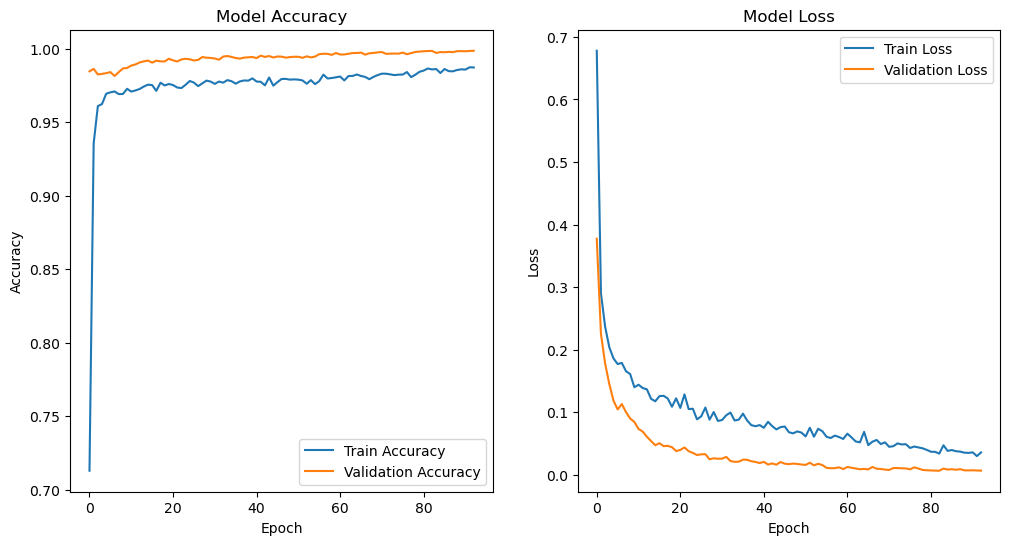

In [8]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()